In [1]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png"))
options(jupyter.plot_scale = 1.5)
require("pacman")
options(warn = -1)
pacman::p_load(tidyverse, lubridate, zoo, ggpubr, ggfortify, forecast)

source('../Scripts/ReadData.R')
source('../Scripts/ModelSelection.R')
source('../Scripts/ResidualAnalysis.R')
source('../Scripts/Forecasting.R')

Loading required package: pacman



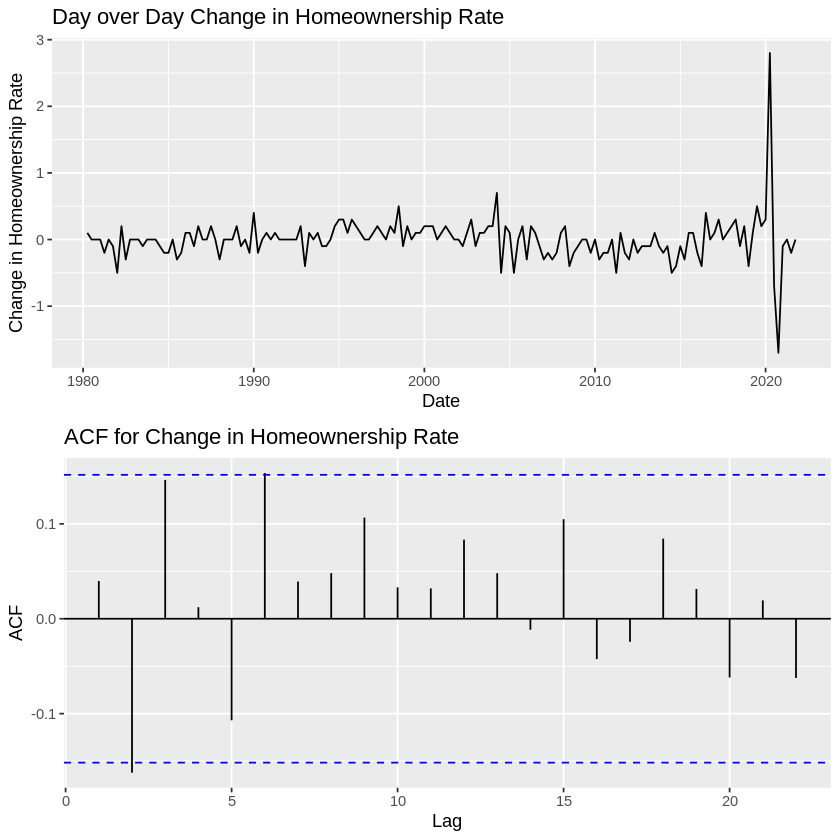

In [2]:
homeownership <- read_homeownership()
homeownership_diff <- homeownership %>% mutate(dValue = Value - lag(Value)) %>% drop_na %>% select(-Value)

p1 <- homeownership_diff %>% ggplot() +
    geom_line(aes(x = Date, y = dValue)) +
    labs(y = "Change in Homeownership Rate", title = "Day over Day Change in Homeownership Rate")
p2 <- ggAcf(homeownership_diff$dValue) + 
    labs(title = "ACF for Change in Homeownership Rate")
ggarrange(p1, p2, nrow = 2, ncol = 1)

In [3]:
outliers <- tsoutliers(homeownership$Value)
outliers
cleaned_homeownership <- homeownership
cleaned_homeownership$Value[outliers$index] <- outliers$replacements

$index
[1] 162 163

$replacements
[1] 65.43333 65.56667

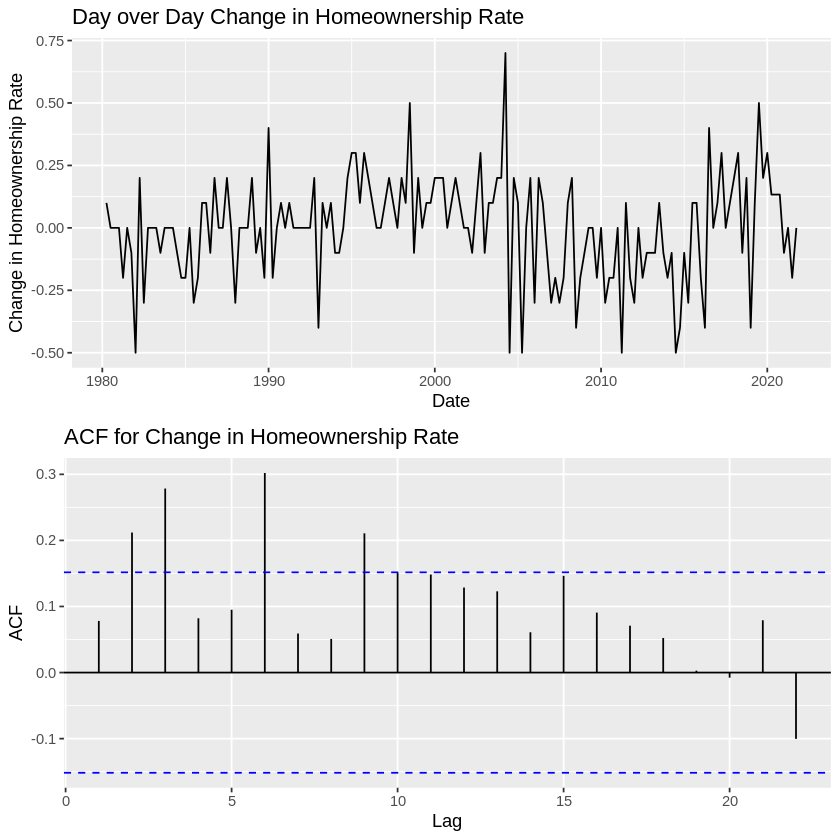

In [4]:
homeownership_diff <- cleaned_homeownership %>% mutate(dValue = Value - lag(Value)) %>% drop_na %>% select(-Value)

p1 <- homeownership_diff %>% ggplot() +
    geom_line(aes(x = Date, y = dValue)) +
    labs(y = "Change in Homeownership Rate", title = "Day over Day Change in Homeownership Rate")
p2 <- ggAcf(homeownership_diff$dValue) + 
    labs(title = "ACF for Change in Homeownership Rate")
ggarrange(p1, p2, nrow = 2, ncol = 1)

In [5]:
test_split = 4
train <- head(homeownership_diff, -test_split)
test <- tail(homeownership_diff, test_split)
arima_comp <- find_best_arima(train$dValue, 0:5, 0:2, 0:5)
head(arima_comp)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,5,0,4,-74.22447
2,5,0,5,-72.88708
3,3,0,3,-71.75546
4,2,1,3,-70.07758
5,3,0,4,-69.52296
6,4,0,3,-69.52208



	Box-Ljung test

data:  residuals(model)
X-squared = 2.5973, df = 1, p-value = 0.107


	Box-Ljung test

data:  residuals(model)^2
X-squared = 9.936, df = 1, p-value = 0.001621



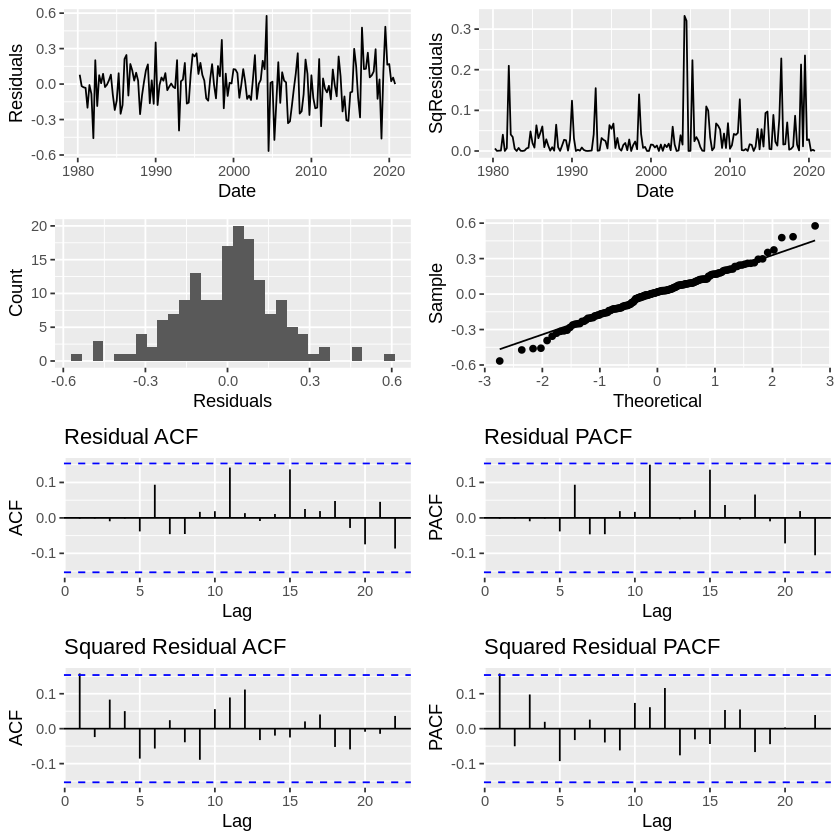

In [6]:
best_order <- arima_comp[1,1:3] %>% as.numeric
arima_model <- arima(train$dValue, order = best_order, method = "ML")
residual_analysis(arima_model, train$Date)
box_tests(arima_model, best_order[1] + best_order[3])

In [7]:
ugarch_comp <- find_best_ugarch(homeownership_diff$dValue, 4, 4, 0:5, 0:5, 0:2, 0:2, test_size = test_split)
head(ugarch_comp$Final)

,p,q,m,n,BIC
,<int>,<int>,<int>,<int>,<dbl>
1,5,3,0,1,-0.4219257
2,5,3,2,1,-0.3334962
3,5,3,2,0,-0.2150043
4,5,3,0,0,-0.2133050
5,5,3,1,0,-0.2046343
6,5,3,0,2,-0.1698878



	Box-Ljung test

data:  residuals(model)
X-squared = 13.786, df = 1, p-value = 0.0002049


	Box-Ljung test

data:  residuals(model)^2
X-squared = 7.9547, df = 1, p-value = 0.004796



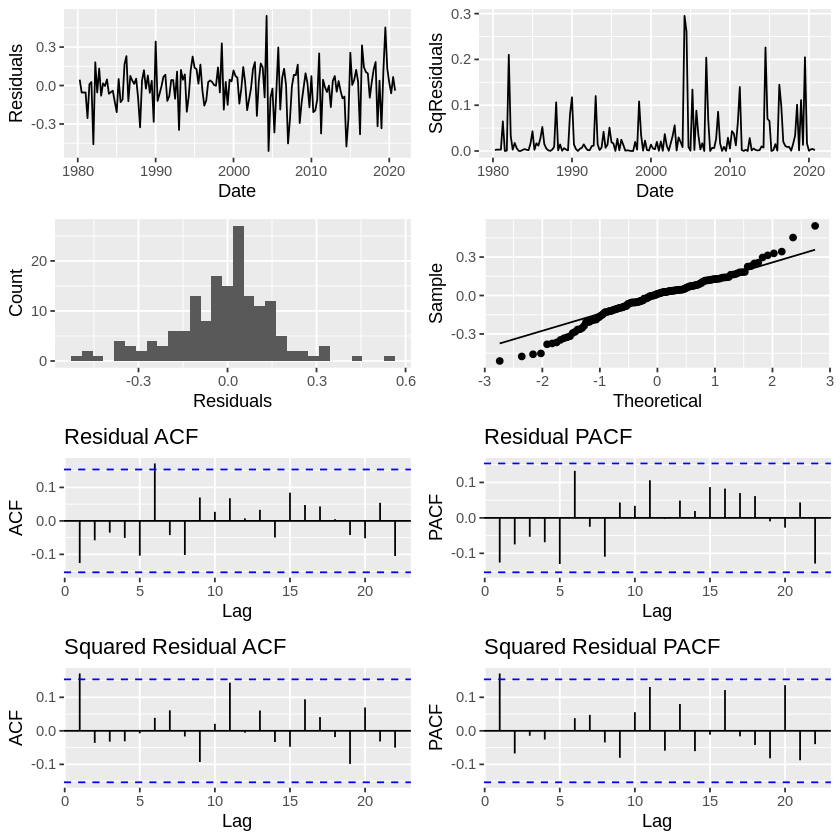

In [8]:
best_order <- as.numeric(ugarch_comp$Final[1,1:4])
spec1 <- ugarchspec(variance.model=list(garchOrder=c(best_order[3:4])),
                     mean.model=list(armaOrder=c(best_order[1:2]),
                                     include.mean=T), distribution.model="std")
ugarch_model1 <- ugarchfit(spec1, homeownership_diff$dValue, solver = 'hybrid', out.sample = test_split)
residual_analysis(ugarch_model1, train$Date)
box_tests(ugarch_model1, sum(best_order))


	Box-Ljung test

data:  residuals(model)
X-squared = 7.8143, df = 1, p-value = 0.005184


	Box-Ljung test

data:  residuals(model)^2
X-squared = 12.082, df = 1, p-value = 0.000509



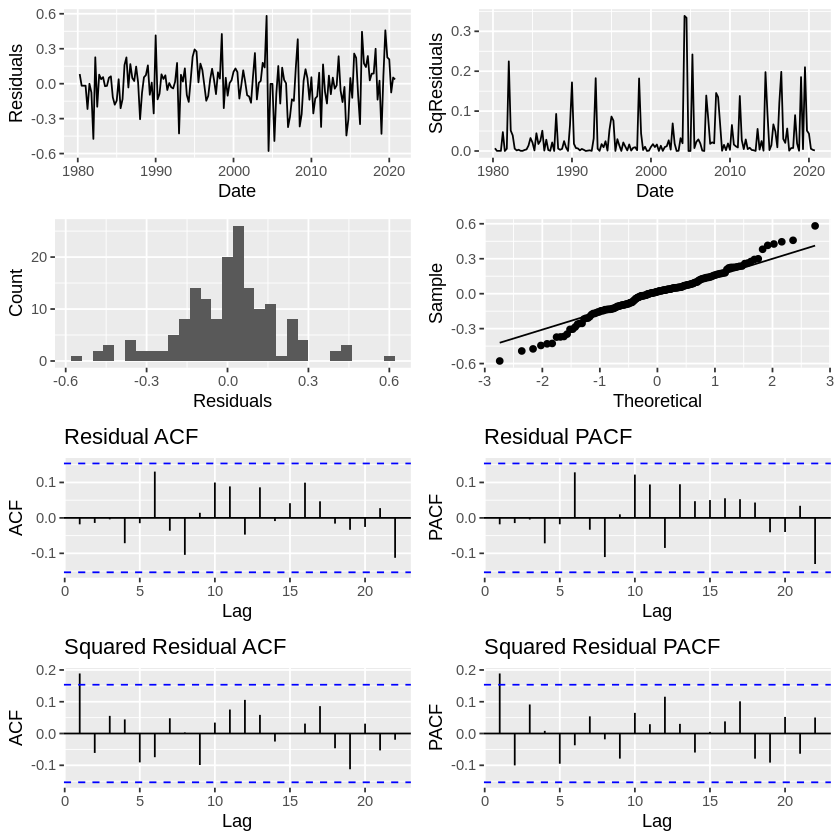

In [10]:
spec2 <- ugarchspec(variance.model=list(garchOrder=c(1,1)),
                     mean.model=list(armaOrder=c(best_order[1:2]),
                                     include.mean=T), distribution.model="std")
ugarch_model2 <- ugarchfit(spec2, homeownership_diff$dValue, solver = 'hybrid', out.sample = test_split)
residual_analysis(ugarch_model2, train$Date)
box_tests(ugarch_model2, sum(best_order))

PM =  5.91615

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.1828552,0.2016768,0.1828552,-Inf,Inf


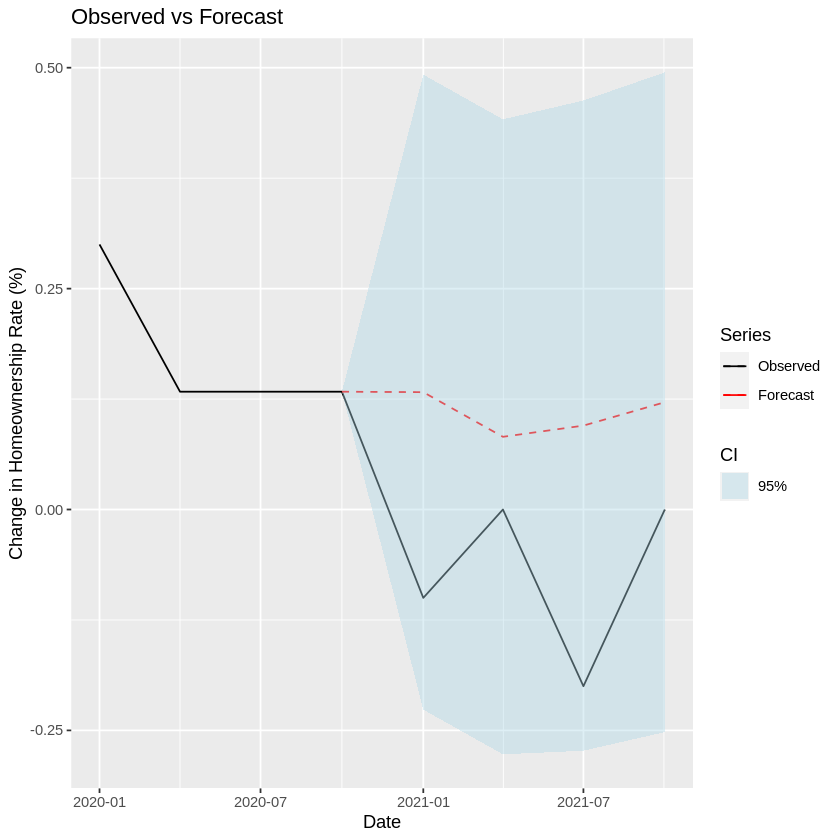

In [11]:
fc <- forecast_arima(arima_model, homeownership_diff$Date, homeownership_diff$dValue, test_split, 95,
                    y_lab = "Change in Homeownership Rate (%)")
fc$plot
fc_data <- tail(fc$data, test_split)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

PM =  3.477633

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.07447534,0.1546245,0.1535631,NaN,Inf


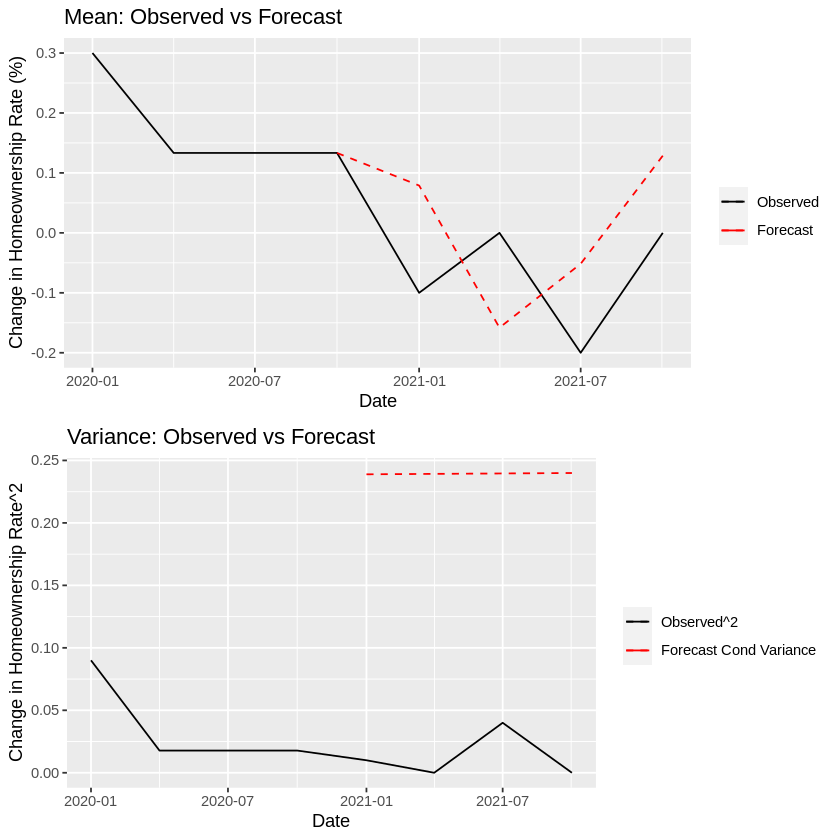

In [12]:
fc <- forecast_ugarchroll(ugarch_model1, homeownership_diff$Date, test$dValue, test_split,
                          y_lab = c("Change in Homeownership Rate (%)", "Change in Homeownership Rate^2"))
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

PM =  3.93954

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.1178569,0.1645732,0.1309458,NaN,Inf


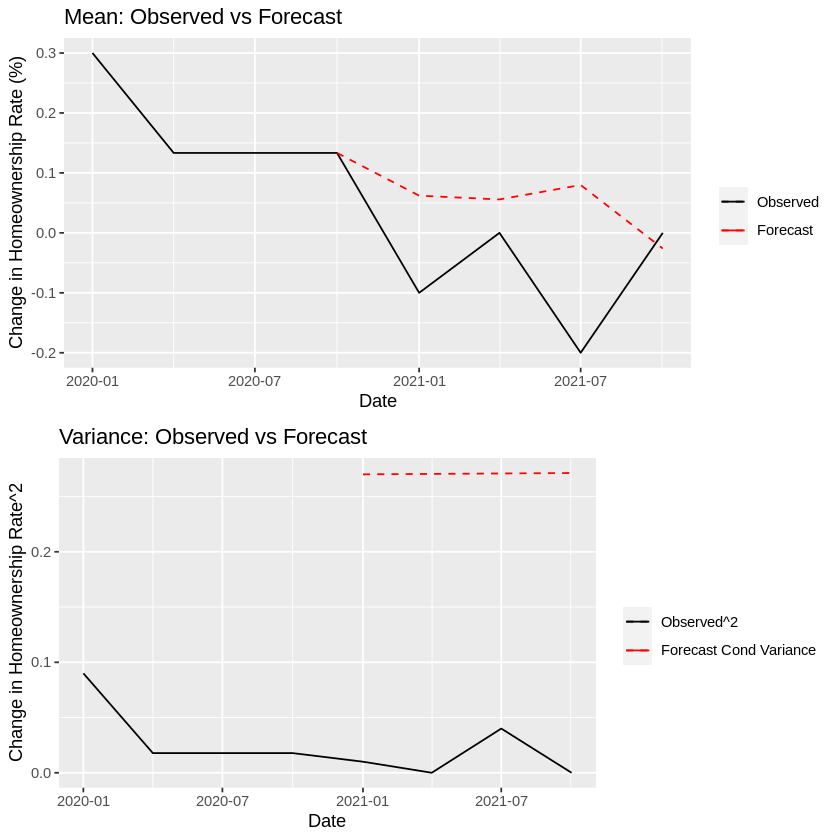

In [13]:
fc <- forecast_ugarchroll(ugarch_model2, homeownership_diff$Date, test$dValue, 4,
                          y_lab = c("Change in Homeownership Rate (%)", "Change in Homeownership Rate^2"))
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)